# Using a Cellphone Accelerometer to Identify Parkinson’s Disease
## Simon Mercer
### Data Science Student, Galvanize, Inc., March 2017
<i>does this work?</i>


In [62]:
import numpy as np
import pandas as pd
import seaborn as sns
import itertools as it
import sqlalchemy
from matplotlib import pyplot as plt
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import binarize
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from IPython.core import display as ICD


In [4]:
# import custom helper functions and other dependencies
from src.python import notebook_funcs as nb

# notebook-specific settings
%matplotlib inline
sns.set()

In [5]:
# connect to PostgreSQL
conn = nb.connect('tremor')

# prepare a list of gesture names in the order they are processed
gestures = ['Lap Left', 'Lap Right', 'Nose Left', 'Nose Right', 'Shoulder Left', 'Shoulder Right']

# get all gesture data
all_gesture_dfs = nb.get_datasets(conn)

In [54]:
def make_pipe(reg=1000):
    # logistic regression hyperparameters
    lr_penalty = 'l1' # l1=lasso, l2=ridge? -- check this
    lr_C = reg # C=1000 suppresses regularization, default is C=1.0
    lr_class_weight = 'balanced' # automatically adjust weights inversely proportional to class frequencies
    lr_max_iter = 100 # insensitive between 50 and 10000 - leave
    lr_solver = 'liblinear' # best solver for this problem
    lr_tol = 0.0001

    # build a logistic regression pipeline with scaling and regularization
    lr_scaler = StandardScaler(with_mean=True, with_std=True)
    lr = LogisticRegression(
            penalty=lr_penalty,
            C=lr_C, 
            class_weight=lr_class_weight, 
            max_iter=lr_max_iter, 
            solver=lr_solver,
            tol=lr_tol)

    lr_pipeline = make_pipeline(lr_scaler, lr)
    return [lr_pipeline, lr]

In [55]:
num_folds = 10 # optimal or close to it
cv_all_feats = [] # store cross-validation scores here for comparison later

for i, gesture in enumerate(all_gesture_dfs):
    X, y = nb.create_predictor_set(gesture)
    
    if i == 0:
        # this will be the same for all six sets, so print for set 0
        print "Null error rate for all data sets is {}\n".format(pd.Series.sum(y)/float(pd.Series.count(y)))
    
    print "Gesture {}".format(gestures[i])
    
    # fit the pipeline with ALL the data for each gesture
    (my_pipe, my_lr) = make_pipe()
    my_pipe.fit(X, y)
    
    # return the overall model accuracy
    print "Model accuracy (all data): {}".format(my_pipe.score(X, y))
    
    # get coefficient values for all Xs
    all_coeffs = pd.DataFrame(zip(X.columns, np.transpose(my_lr.coef_.tolist()[0])),columns=['param','coeff'])
    # returns only the nonzero coefficients
    nonzero_coeffs = all_coeffs[all_coeffs.coeff != 0]
    # display coefficient values as formatted table
    ICD.display(nonzero_coeffs.sort_values('coeff', ascending=False).T)

    # evaluate model accuracy using k-fold cross validation
    cv_probabilities = cross_val_score(my_pipe, X, y, cv=num_folds)
    mean_acc = np.mean(cv_probabilities)
    cv_all_feats.append(mean_acc)
    print '{}-fold cross-validation: {}\n\n'.format(num_folds, mean_acc)


Null error rate for all data sets is 0.518181818182

Gesture Lap Left
Model accuracy (all data): 0.986363636364


,37,9,89,1,3,8,24,81,54,2,...,74,46,30,32,75,15,59,7,6,94
param,tkeoy,iqrx,meanaj,meanx,modex,q3x,sdy,tkeoaa,rangez,sdx,...,q3aa,sdz,q3y,rangey,iqraa,tkeox,tkeoz,medianx,q1x,q1aj
coeff,40.2846,26.7468,23.4269,22.157,19.6912,19.1014,17.9638,17.295,16.5782,14.8352,...,-10.7604,-10.8955,-13.0874,-13.5816,-14.5005,-21.5015,-21.8563,-23.8808,-26.7737,-51.4248


10-fold cross-validation: 0.695416901939


Gesture Lap Right
Model accuracy (all data): 0.986363636364


,91,7,37,31,59,74,29,9,30,72,...,76,33,28,10,96,95,97,1,53,6
param,modeaj,medianx,tkeoy,iqry,tkeoz,q3aa,mediany,iqrx,q3y,q1aa,...,rangeaa,acfy,q1y,rangex,q3aj,medianaj,iqraj,meanx,iqrz,q1x
coeff,12.5139,12.4459,10.5312,10.4442,8.79997,8.60372,8.49698,8.2091,8.0653,7.52276,...,-5.07932,-5.46413,-6.0981,-6.38396,-6.65355,-7.09856,-7.25713,-8.7784,-9.06876,-12.3457


10-fold cross-validation: 0.723969508752


Gesture Nose Left
Model accuracy (all data): 1.0


,3,0,45,15,40,75,81,61,101,97,...,20,27,78,77,22,95,51,46,42,73
param,modex,age,meanz,tkeox,f0fy,iqraa,tkeoaa,p0z,dfaaj,iqraj,...,medianf0fx,kury,zcraa,acfaa,tlagx,medianaj,medianz,sdz,medianf0fy,medianaa
coeff,34.5862,28.3876,26.6502,26.343,20.0314,16.5989,16.1533,15.1472,14.4995,13.9457,...,-12.8663,-13.2222,-13.2264,-13.7848,-16.872,-20.4195,-20.6444,-20.9233,-21.5513,-34.6524


10-fold cross-validation: 0.667212497647


Gesture Nose Right
Model accuracy (all data): 1.0


,24,71,29,6,0,25,102,101,8,73,...,72,31,98,76,3,28,23,49,30,1
param,sdy,kuraa,mediany,q1x,age,modey,cvaj,dfaaj,q3x,medianaa,...,q1aa,iqry,rangeaj,rangeaa,modex,q1y,meany,kurz,q3y,meanx
coeff,58.4314,49.4571,47.7001,34.0281,23.8696,23.455,21.9916,20.6596,20.1897,16.3978,...,-12.713,-12.9088,-13.9199,-15.7596,-18.4319,-19.6232,-27.0244,-32.9346,-34.3976,-39.1159


10-fold cross-validation: 0.681309994353


Gesture Shoulder Left
Model accuracy (all data): 0.990909090909


,59,50,1,37,73,72,95,28,54,32,...,75,98,76,53,68,3,94,7,81,15
param,tkeoz,q1z,meanx,tkeoy,medianaa,q1aa,medianaj,q1y,rangez,rangey,...,iqraa,rangeaj,rangeaa,iqrz,sdaa,modex,q1aj,medianx,tkeoaa,tkeox
coeff,126.675,89.6948,72.2139,66.1892,60.8218,55.1616,43.0607,39.504,30.6455,22.3286,...,-19.3521,-20.9904,-22.923,-24.7689,-26.5071,-37.4247,-53.4207,-66.2668,-66.2806,-68.4247


10-fold cross-validation: 0.623941276115


Gesture Shoulder Right
Model accuracy (all data): 1.0


,15,32,59,3,97,72,29,78,5,44,...,10,37,95,90,68,46,47,28,24,81
param,tkeox,rangey,tkeoz,modex,iqraj,q1aa,mediany,zcraa,kurx,tlagy,...,rangex,tkeoy,medianaj,sdaj,sdaa,sdz,modez,q1y,sdy,tkeoaa
coeff,108.98,56.5313,53.7933,47.3657,21.9754,18.2479,17.059,16.1474,16.0031,14.5097,...,-16.8986,-17.0321,-17.3352,-18.0898,-22.7628,-26.3339,-29.8565,-32.7037,-34.1186,-45.4633


10-fold cross-validation: 0.646113306983




Gesture Lap Left
k=1, accuracy=0.816233766234, features(age)
k=2, accuracy=0.856371165067, features(age,iqrx)
k=3, accuracy=0.861133069829, features(age,iqrx,tlagz)
k=4, accuracy=0.861133069829, features(age,iqrx,tlagz,acfx)
k=5, accuracy=0.861133069829, features(age,iqrx,tlagz,acfx,cvx)
k=6, accuracy=0.861133069829, features(age,p0x,tlagz,iqrx,acfx,cvx)
k=7, accuracy=0.861133069829, features(age,p0x,tlagz,kury,iqrx,acfx,cvx)
k=8, accuracy=0.861547148504, features(age,p0x,tlagz,kury,q1aj,iqrx,acfx,cvx)
k=9, accuracy=0.865894974591, features(age,tlagz,tkeoy,iqrx,acfx,cvx,p0x,kury,q1aj)
k=10, accuracy=0.865894974591, features(age,tlagz,tkeoy,q1x,iqrx,acfx,cvx,p0x,kury,q1aj)
Selecting k=3


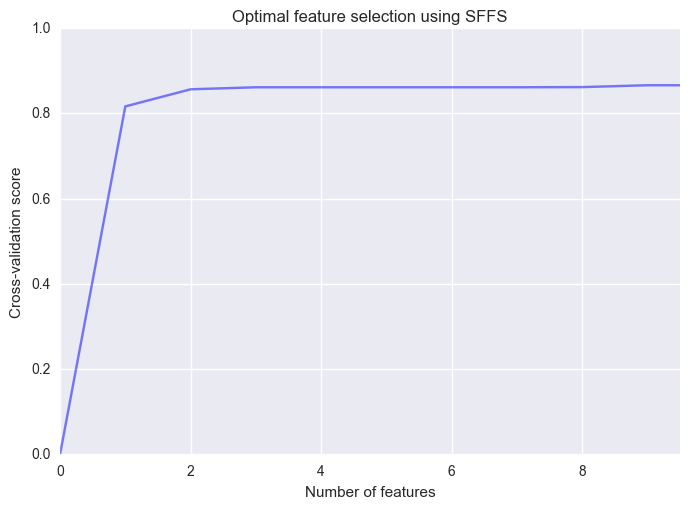

Gesture Lap Right
Gesture Nose Left
Gesture Nose Right
Gesture Shoulder Left
Gesture Shoulder Right


In [19]:
# WARNING - VERY SLOW - >2HRS ON LAPTOP
# use Sequential Floating Forward Selection to identify the best features
# to use to classify each gesture - does this for values of k from 1-10

max_feats = 10

# the best feature set is the last one to increase accuracy
# over its predecessor of more than min_increment
min_increment = 0.001

for i, gesture in enumerate(all_gesture_dfs):

    print "Gesture {}".format(gestures[i])
    X, y = nb.create_predictor_set(gesture)
        
    # make a new pipeline for each gesture
    (my_pipe, my_lr) = make_pipe()
    
    (plot_x, plot_y) = nb.search_features(my_pipe, X, y, max_feats)
    print "Optimal feture set at k={}".format(nb.find_idx(plot_y, min_increment))  
            
    # graph to illustrate optimal number of features
    nb.sffs_plot(plot_x, plot_y)


In [22]:
# the feature selection methodology above (too slow to run in real time)
# recommends the following feature sets, one for each of the six gestures

optimal_feats = [['age','iqrx','tlagz'],
                 ['age','f0x','f0aa','tkeoy','meanaj','iqrx'],
                 ['age','q3z','p0fz'],
                 ['age','dfay','modex','zcrx'],
                 ['age','q1aa','zcrx','p0y'],
                 ['age','f0x','iqrz','sdy']]


In [29]:
cv_selected_feats = [] # store cross-validation scores for selected feature set

for i, gesture in enumerate(all_gesture_dfs):
    X, y = nb.create_predictor_set(gesture, optimal_feats[i])
    
    # re-evaluate model accuracy using k-fold cross validation
    # with the selected feature set
    cv_probabilities = cross_val_score(my_pipe, X, y, cv=num_folds)
    cv_selected_feats.append(np.mean(cv_probabilities))

# compare model with restricted feature sets
percentile_list = pd.DataFrame(
    {'Gesture': gestures,
     'All features': cv_all_feats,
     'Selected features': cv_selected_feats
    })

print "Cross-validation (k={})".format(num_folds)
percentile_list[['Gesture', 'All features', 'Selected features']]


Cross-validation (k=10)


,Gesture,All features,Selected features
0,Lap Left,0.699765,0.861133
1,Lap Right,0.729145,0.888660
2,Nose Left,0.667627,0.829889
3,Nose Right,0.676548,0.829691
4,Shoulder Left,0.624139,0.861350
5,Shoulder Right,0.646113,0.848108


In [ ]:
With feature selection, the mean accuracy across all six gestures is 0.853, and would have 
lower variance then any model alone.


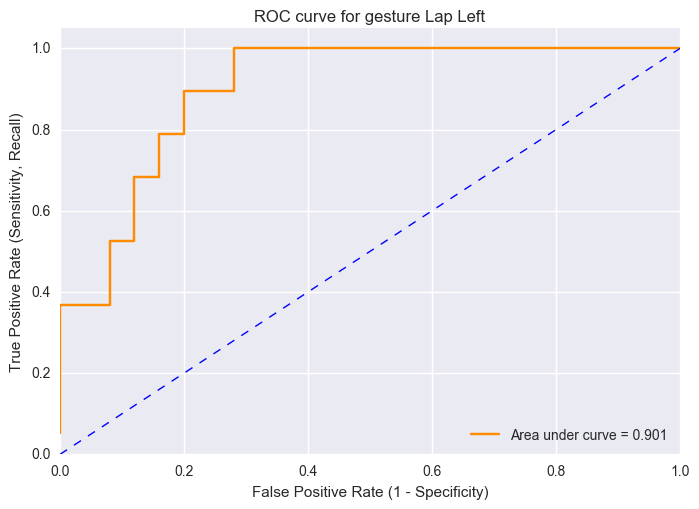

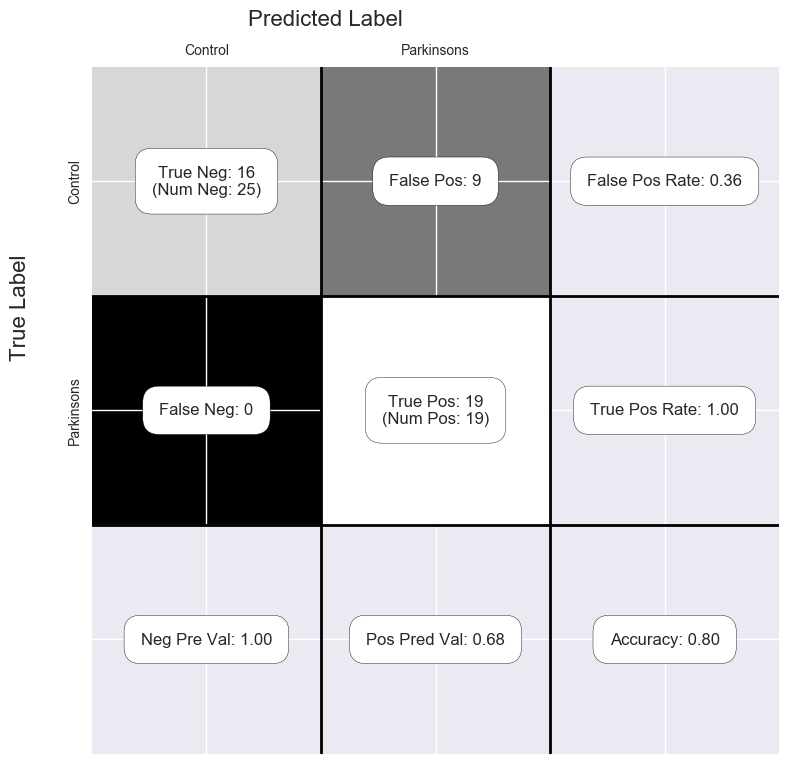

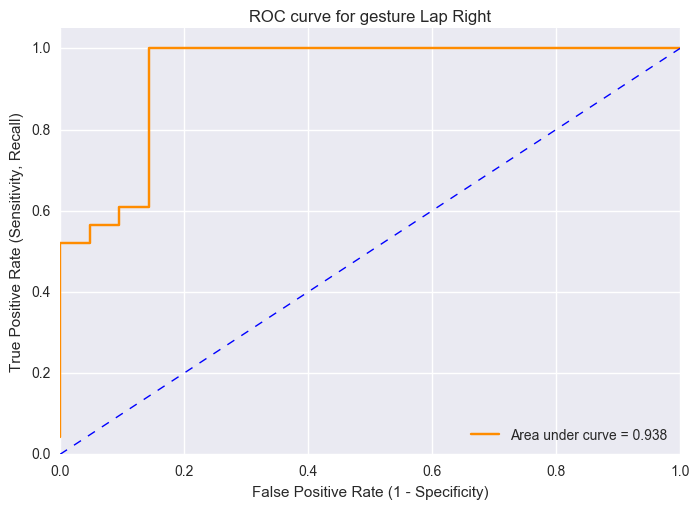

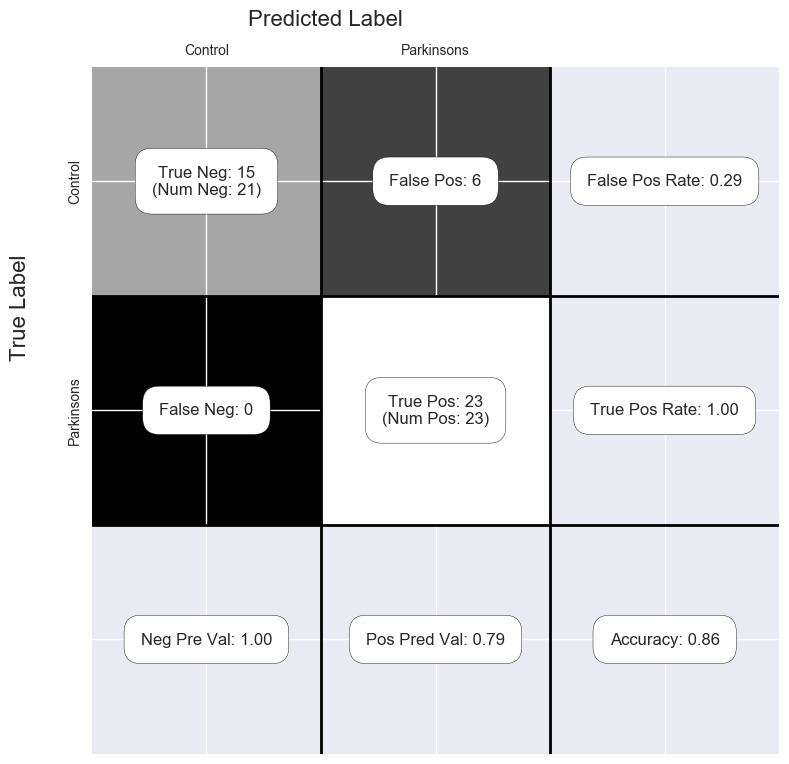

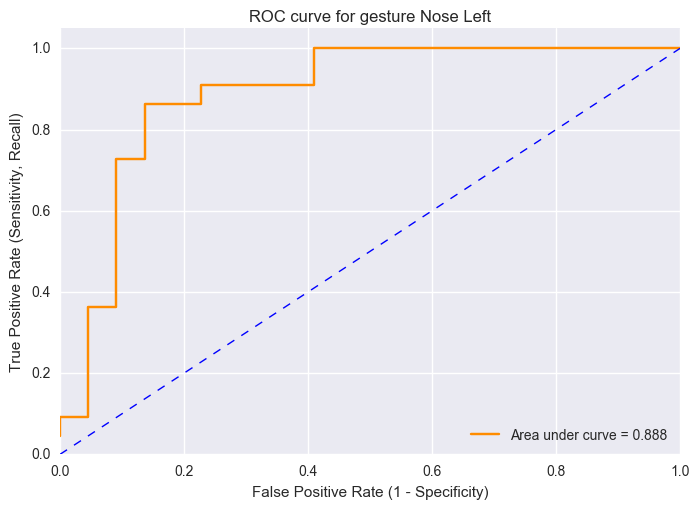

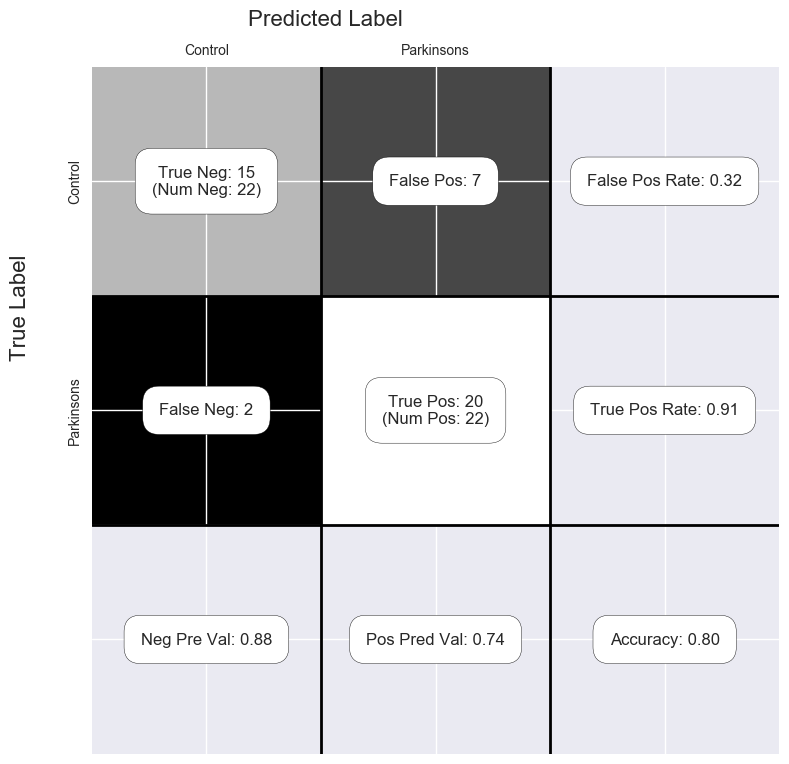

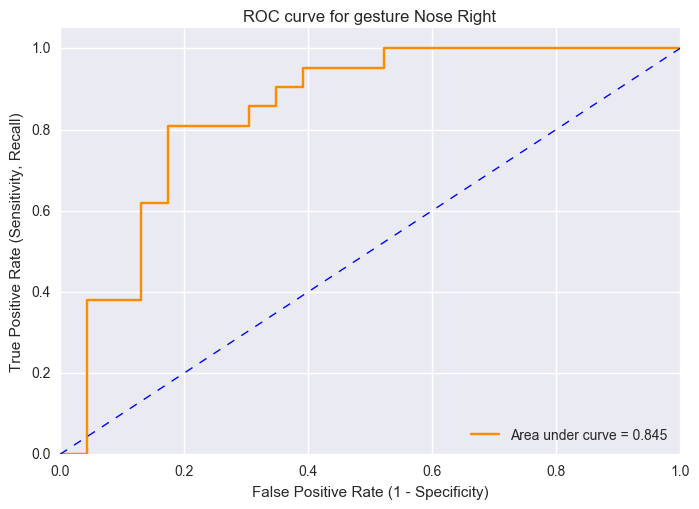

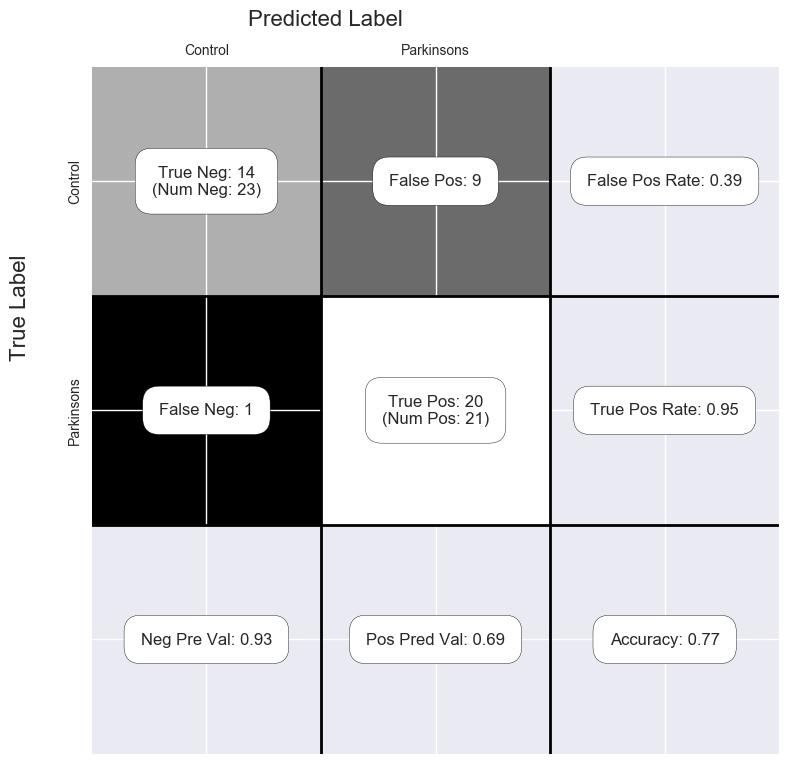

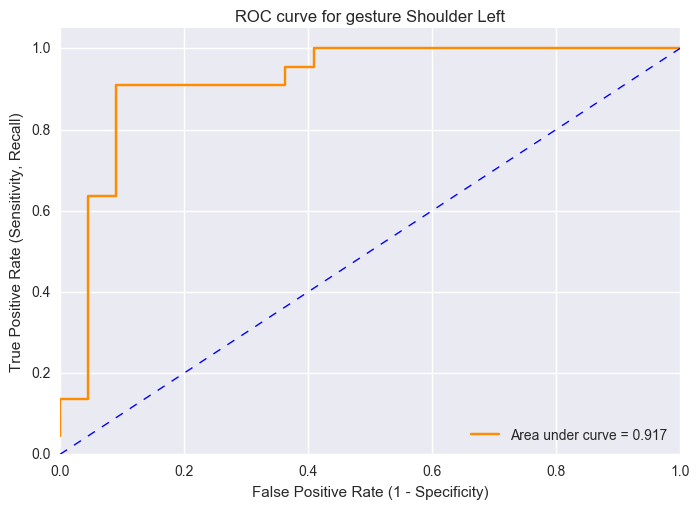

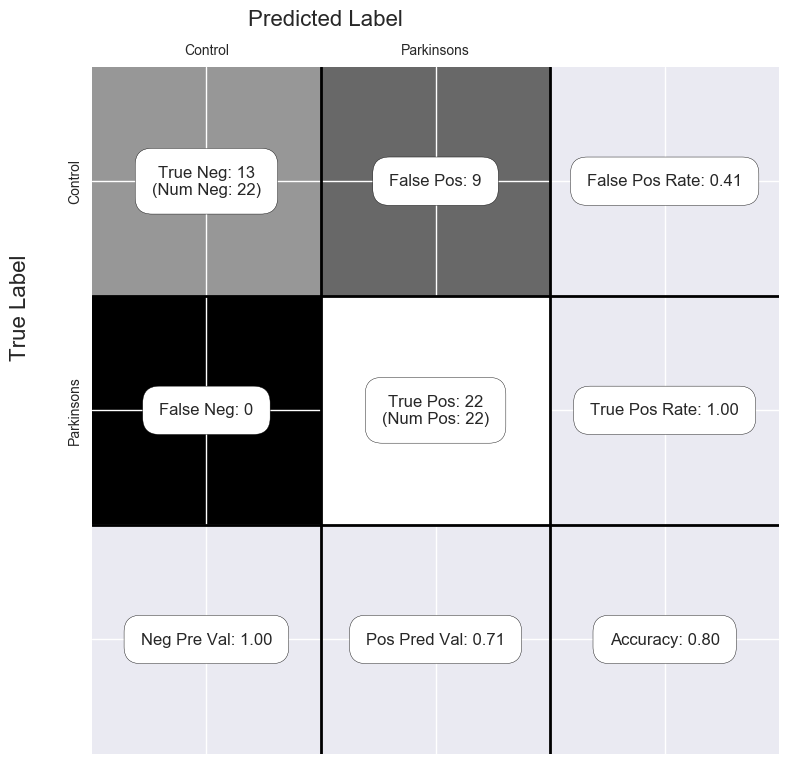

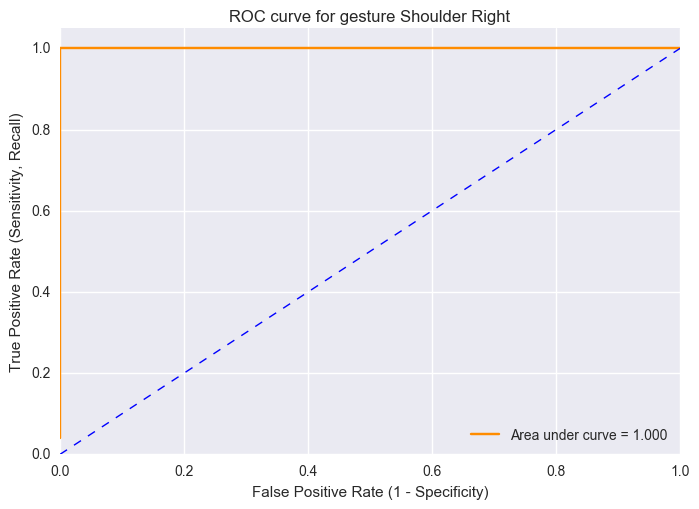

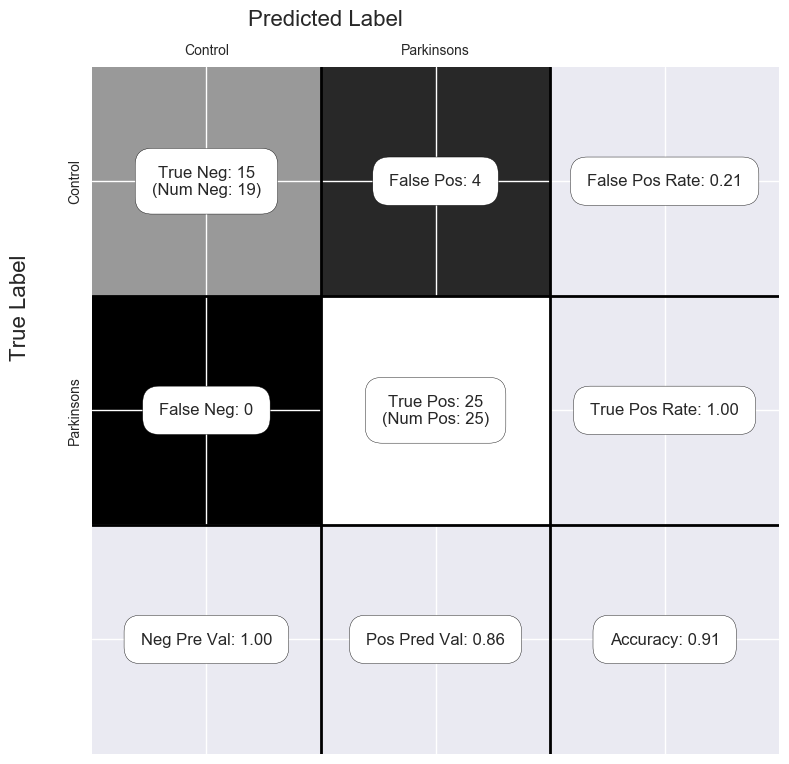

In [39]:
# build ROC curves and Confusion Matrices for each gesture to evaluate
# classifier performance

for i, gesture in enumerate(all_gesture_dfs):
    
    train, test = train_test_split(gesture, test_size = 0.2)
    X_train = train[optimal_feats[i]]
    y_train = train['datagroups']
    X_test = test[optimal_feats[i]]
    y_test = test['datagroups']
    
    # make a new pipeline for each gesture
    (my_pipe, my_lr) = make_pipe()

    # generate data for the ROC curve
    my_pipe.fit(X_train, y_train)
    roc_probabilities = my_pipe.predict_proba(X_test)[:, 1]

    # build the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, roc_probabilities, pos_label=None, sample_weight=None, drop_intermediate=True)
    roc_auc = roc_auc_score(y_test, roc_probabilities)
    
    # plot the ROC curve
    nb.roc_on(fpr, tpr, roc_auc, gestures[i])
    
    # build and then display confusion matrix
    nb.build_cfm(roc_probabilities, y_test)
    

In [68]:
# performance of combined models

for m1,m2 in it.combinations([0,1,2,3,4,5], 2):
    print "\nJoint model for gestures {} and {}:".format(gestures[m1],gestures[m2])
    print "(respective individual accuracies {} and {})".format(cv_selected_feats[m1], cv_selected_feats[m2])

    model_1_X, y = nb.create_predictor_set(all_gesture_dfs[m1], optimal_feats[m1])
    model_2_X = nb.create_predictor_set(all_gesture_dfs[m2], optimal_feats[m2])[0]

    # age will be in both X data frames - remove one copy
    model_1_X.drop('age', axis=1, inplace=True)

    two_gestures = pd.concat([X_lr, X_sl], axis=1)

    for reg_val in ([1000,100,10,1,0.5,0.1]):
        # make a pipeline
        (my_pipe, my_lr) = make_pipe(reg=reg_val)

        # evaluate model accuracy using k-fold cross validation
        pair_probs = cross_val_score(my_pipe, two_gestures, y, cv=num_folds)
        mean_pair_acc = np.mean(pair_probs)

        print '{}-fold cross-validation reg={} :\t{}'.format(num_folds, reg_val, mean_pair_acc)




Joint model for gestures Lap Left and Lap Right:
(respective individual accuracies 0.861133069829 and 0.888659890834)
10-fold cross-validation reg=1000 :	0.86176359872
10-fold cross-validation reg=100 :	0.86176359872
10-fold cross-validation reg=10 :	0.857415772633
10-fold cross-validation reg=1 :	0.856785243742
10-fold cross-validation reg=0.5 :	0.852437417655
10-fold cross-validation reg=0.1 :	0.825127046866

Joint model for gestures Lap Left and Nose Left:
(respective individual accuracies 0.861133069829 and 0.829888951628)
10-fold cross-validation reg=1000 :	0.86176359872
10-fold cross-validation reg=100 :	0.86176359872
10-fold cross-validation reg=10 :	0.857415772633
10-fold cross-validation reg=1 :	0.856785243742
10-fold cross-validation reg=0.5 :	0.852437417655
10-fold cross-validation reg=0.1 :	0.825127046866

Joint model for gestures Lap Left and Nose Right:
(respective individual accuracies 0.861133069829 and 0.82969132317)
10-fold cross-validation reg=1000 :	0.86176359872
1